In [1]:
import hddCRP.simulations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx

In [9]:
# session_lengths = [50,55,53,50,50, 50,50,50,50,50,50,50,50,50,50] # number of observations (actions) per session
# session_labels = ['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']

session_lengths = [4,3]#[10, 15]
session_labels  = ['A', 'B']

action_labels = ['L', 'R', 'S']

depth = 3; # look 2 actions in the past
alphas = [2,3,3] # concentration parameter
between_session_time_constants = np.array([[3, 1],
                                            [1, 3]]) # units = sessions
within_session_time_constant = 20 # units = actions

seqs, connection_data = hddCRP.simulations.simulate_sequential_hddCRP(session_lengths, session_labels, action_labels, depth, alphas, between_session_time_constants, within_session_time_constant)
print(seqs[:2])


[array(['R', 'R', 'S', 'R'], dtype='<U1'), array(['L', 'S', 'L'], dtype='<U1')]


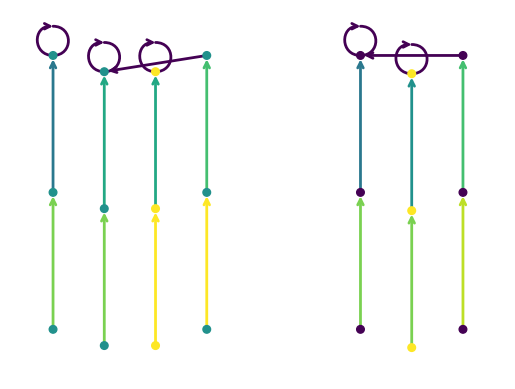

In [13]:
num_sessions_to_plot = min(3, len(session_lengths));

if(np.sum(session_lengths[:num_sessions_to_plot]) < 50):
    ax = plt.gca()
    hddCRP.simulations.make_graph_plot(connection_data, ax, num_sessions=num_sessions_to_plot)
    plt.show()
else:
    print("not plotting graph: too many nodes")


In [10]:
model = hddCRP.simulations.create_hddCRPModel_from_simulated_sequential_hddCRP(seqs, connection_data)

In [6]:
#model.run_gibbs_sweep()
# model._gibbs_sample_single_node(0, 0)

KeyboardInterrupt: 

In [11]:
print(model._C_ptr)

[[0 0 0]
 [1 1 1]
 [2 2 2]
 [1 3 3]
 [4 4 4]
 [5 5 5]
 [4 6 6]]


In [14]:
print(model._C_tables)

[[ 0  5 12]
 [ 1  6 13]
 [ 2  7 14]
 [ 1  8 15]
 [ 3  9 16]
 [ 4 10 17]
 [ 3 11 18]]
